3.2. Linear Regression Implementation from Scratch


In [ ]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [ ]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

3.2.1. Generating the Dataset

To keep things simple, we will construct an artificial dataset according to a linear model with additive noise. 

In the following code snippet, we generate a dataset containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution. Thus our synthetic dataset will be a matrix  X∈R1000×2 .

The true parameters generating our dataset will be  w=[2,−3.4]⊤  and  b=4.2 , and our synthetic labels will be assigned according to the following linear model with the noise term  ϵ : y=Xw+b+ϵ.

In [ ]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-1.3381385  -0.18684343], shape=(2,), dtype=float32) 
label: tf.Tensor([2.1540844], shape=(1,), dtype=float32)


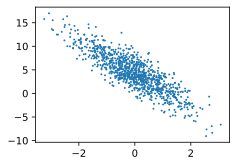

In [ ]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

3.2.2. Reading the Dataset

Training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model.

In the following code, we define the data_iter function to demonstrate one possible implementation of this functionality. The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size. Each minibatch consists of a tuple of features and labels.

In [ ]:
#The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size. 
#Each minibatch consists of a tuple of features and labels.

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [ ]:
#To build some intuition, let us read and print the first small batch of data examples.
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[-1.0144693  -1.6479822 ]
 [ 0.00516094  0.60044783]
 [ 0.06944708  0.06586037]
 [ 0.9471354   0.06025887]
 [ 0.24887113 -0.51031464]
 [ 0.93880093 -0.63949925]
 [-1.0236202   1.0598183 ]
 [ 0.6699408  -2.9345446 ]
 [ 0.00728134 -0.5479535 ]
 [-1.6650892  -1.8532959 ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 7.7570124]
 [ 2.172779 ]
 [ 4.108021 ]
 [ 5.878134 ]
 [ 6.418123 ]
 [ 8.260455 ]
 [-1.4487361]
 [15.522685 ]
 [ 6.0692186]
 [ 7.171817 ]], shape=(10, 1), dtype=float32)


3.2.3. Initializing Model Parameters

Before we can begin **optimizing our model’s parameters** by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [ ]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

3.2.4. Defining the Model

Next, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply *take the matrix-vector dot product of the input features  X  and the model weights  w , and add the offset  b  to each example.*

In [ ]:
# Note that below  Xw  is a vector and  b  is a scalar.
def linreg(X, w, b): 
    """The linear regression model."""
    return tf.matmul(X, w) + b


3.2.5. Defining the Loss Function

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we will use the **squared loss function**.  In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also have the same shape as y_hat.

In [ ]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

3.2.6. Defining the Optimization Algorithm

The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size. The size of the update step is determined by the learning rate lr. Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size (batch_size), so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [ ]:
def sgd(params, grads, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

3.2.7. Training

We are ready to implement the main training loop.
In each iteration, we will grab a **minibatch** of training examples, and pass them through our model to** obtain a set of predictions**. After **calculating the loss**, we initiate **the backwards pass** through the network, storing the gradients with respect to each parameter. Finally, we will call the **optimization algorithm sgd** to update the model parameters.

In each **epoch**, we will iterate through the entire dataset (using the data_iter function) once passing through every example in the training dataset (assuming that the number of examples is divisible by the batch size). The number of epochs **num_epochs** and the **learning rate** lr are both **hyperparameters**, which we set here to 3 and 0.03, respectively

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on l with respect to [`w`, `b`]
        dw, db = g.gradient(l, [w, b])
        # Update parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.032842
epoch 2, loss 0.000112
epoch 3, loss 0.000050


In [ ]:
#Evaluate our success in training by comparing the true parameters with those that we learned through our training loop.
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

print(w)
print(b)

error in estimating w: [ 0.00078785 -0.00095153]
error in estimating b: [0.00051975]
